In [94]:
import os
import shutil
import numpy as np
import cv2 # opencv to read images
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pywt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import joblib

In [43]:
Clr_img1 = cv2.imread('./My_dataset/Munaza/PhotoLESS.jpg')
Clr_img1.shape

(507, 408, 3)

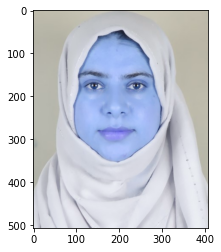

In [44]:
plt.imshow(Clr_img1)

In [45]:
gray_img=cv2.cvtColor(Clr_img1, cv2.COLOR_BGR2GRAY)
gray_img.shape

(507, 408)

In [5]:
gray_img

array([[183, 183, 183, ..., 184, 184, 184],
       [183, 183, 183, ..., 184, 184, 184],
       [183, 183, 183, ..., 184, 184, 184],
       ...,
       [220, 224, 227, ..., 226, 226, 226],
       [220, 224, 227, ..., 227, 224, 224],
       [220, 224, 227, ..., 228, 221, 223]], dtype=uint8)

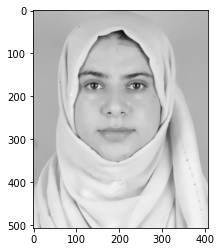

In [6]:
plt.imshow(gray_img, cmap='gray')

In [46]:
face_cascade=cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade=cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

face_extraction=face_cascade.detectMultiScale(Clr_img1,1.3,5)
face_extraction

array([[ 52,  63, 285, 285]])

In [47]:
(x,y,w,h)=face_extraction[0]
x,y,w,h

(52, 63, 285, 285)

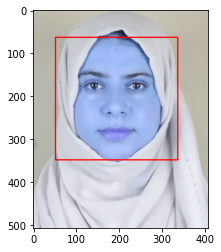

In [48]:
#draw rectangle over the face
face_rectan=cv2.rectangle(Clr_img1,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_rectan)

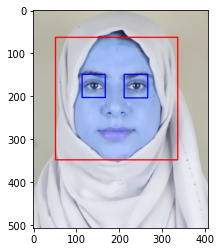

In [49]:
cv2.destroyAllWindows()
for (x,y,w,h) in face_extraction:
    face_rectan=cv2.rectangle(Clr_img1,(x,y),(x+w,y+h),(255,0,0),2)
    Area_gray_img=gray_img[y:y+h, x:x+w] 
    Area_Clr_img=face_rectan[y:y+h, x:x+w] 
    eye_extraction=eye_cascade.detectMultiScale(Area_gray_img)
    for (xe,ye,we,he) in eye_extraction:
        cv2.rectangle(Area_Clr_img,(xe,ye),(xe+we,ye+he),(0,0,255),2)
        
plt.figure()
plt.imshow(face_rectan)
plt.show()

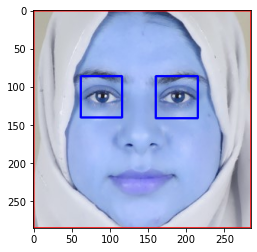

In [50]:
%matplotlib inline
plt.imshow(Area_Clr_img)

In [51]:

face_cascade=cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade=cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

def img_croped(input_img):
    read_inp_img=cv2.imread(input_img)
    inp_img_gray=cv2.cvtColor(read_inp_img, cv2.COLOR_BGR2GRAY)
    ext_face=face_cascade.detectMultiScale(inp_img_gray,1.2,4)
    for (x,y,w,h) in ext_face:
        gray_img_area=inp_img_gray[y:y+h, x:x+w] 
        Clr_img_area=read_inp_img[y:y+h, x:x+w] 
        ext_eyes=eye_cascade.detectMultiScale(gray_img_area)
        if len(ext_eyes)>=2:
            return Clr_img_area
    #else:
        #print("Face and eyes are not visible properly")
        
    
    

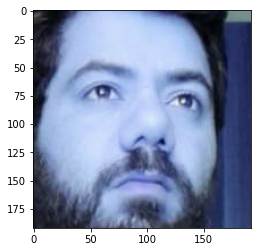

In [52]:
img_crp=img_croped('./My_dataset/Sajad/sajad1.jpg')

plt.imshow(img_crp)

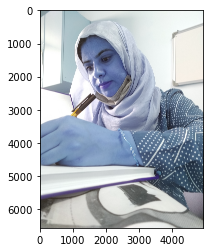

In [53]:
#Data Cleaning
#If face is not clearly visible dont take that picture
Not_clear_visible_img= cv2.imread('./My_dataset/Munaza/Mun_invisible.jpg')
plt.imshow(Not_clear_visible_img)

In [54]:
img_crp1=img_croped('./My_dataset/Munaza/Mun_invisible.jpg')

img_crp1

In [56]:
Dataset_path="./My_dataset/"
crp_data_path="./My_dataset/crp_data/"

family_img_dirs=[]
for each_member in os.scandir(Dataset_path):
    if each_member.is_dir():
        family_img_dirs.append(each_member.path)
        
family_img_dirs

['./My_dataset/Anju_di',
 './My_dataset/Mom',
 './My_dataset/Munaza',
 './My_dataset/Sajad']

In [70]:
#creating folder of face cropped images 
if os.path.exists(crp_data_path):
    shutil.rmtree(crp_data_path)
os.mkdir(crp_data_path)


In [71]:
crp_family_img_dirs=[]
family_names_dicts={}

for family_img_dir in family_img_dirs:
    counter=1
    
    family_name=family_img_dir.split('/')[-1]
    print (family_name)
    
    family_names_dicts[family_name]=[]
    
     #iterate through all images in each folder to create face-croped images
    for each_member in os.scandir(family_img_dir):
        
        Clr_img_area= img_croped(each_member.path)
        
        if Clr_img_area is not None:
            
            crp_img_folder= crp_data_path+family_name
            
            if not os.path.exists(crp_img_folder):
                
                os.mkdir(crp_img_folder)
                
                crp_family_img_dirs.append(crp_img_folder)
                
                print("Generating family_crp_img_folder: ",crp_img_folder)
                
            crp_img_file_name=family_name+str(counter)+".jpg"
            crp_img_file_path=crp_img_folder+"/"+crp_img_file_name
            
            cv2.imwrite(crp_img_file_path,Clr_img_area)
            family_names_dicts[family_name].append(crp_img_file_path)
            counter+=1


Anju_di
Generating family_crp_img_folder:  ./My_dataset/crp_data/Anju_di
Mom
Generating family_crp_img_folder:  ./My_dataset/crp_data/Mom
Munaza
Generating family_crp_img_folder:  ./My_dataset/crp_data/Munaza
Sajad
Generating family_crp_img_folder:  ./My_dataset/crp_data/Sajad


In [72]:
type(family_names_dicts)

dict

In [73]:
def wavlt_transf(inp_img, mode='haar',level=1):
    img_arr=inp_img
    img_arr=cv2.cvtColor(img_arr,cv2.COLOR_RGB2GRAY)
    img_arr=np.float32(img_arr)
    img_arr/=255
    
    coeffs=pywt.wavedec2(img_arr,mode,level=level)
    coeffs_new=list(coeffs)
    coeffs_new[0] *= 0;
    
    img_arr_new=pywt.waverec2(coeffs_new,mode);
    img_arr_new *= 255;
    img_arr_new= np.uint8(img_arr_new)
    
    return img_arr_new
    
    
    

In [74]:
crpd_img = np.array(Clr_img_area)
crpd_img.shape

(339, 339, 3)

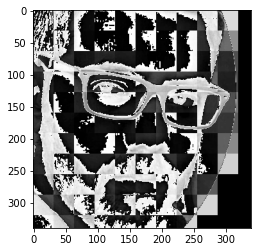

In [75]:
img_Harr= wavlt_transf(crpd_img,'db1',5)
plt.imshow(img_Harr,cmap='gray')

In [62]:
#family_names_dicts

{'Anju_di': ['./My_dataset/crp_data/Anju_di/Anju_di1.jpg',
  './My_dataset/crp_data/Anju_di/Anju_di2.jpg',
  './My_dataset/crp_data/Anju_di/Anju_di3.jpg'],
 'Mom': ['./My_dataset/crp_data/Mom/Mom1.jpg',
  './My_dataset/crp_data/Mom/Mom2.jpg'],
 'Munaza': ['./My_dataset/crp_data/Munaza/Munaza1.jpg',
  './My_dataset/crp_data/Munaza/Munaza2.jpg',
  './My_dataset/crp_data/Munaza/Munaza3.jpg',
  './My_dataset/crp_data/Munaza/Munaza4.jpg',
  './My_dataset/crp_data/Munaza/Munaza5.jpg',
  './My_dataset/crp_data/Munaza/Munaza6.jpg',
  './My_dataset/crp_data/Munaza/Munaza7.jpg'],
 'Sajad': ['./My_dataset/crp_data/Sajad/Sajad1.jpg',
  './My_dataset/crp_data/Sajad/Sajad2.jpg',
  './My_dataset/crp_data/Sajad/Sajad3.jpg']}

In [76]:
label_dict={}
counter1=0
for family_name in family_names_dicts.keys():
    label_dict[family_name]=counter1
    counter1=counter1+1
label_dict


{'Anju_di': 0, 'Mom': 1, 'Munaza': 2, 'Sajad': 3}

In [84]:
#iterate thru dicts

X_data=[]
Y_data=[]

for family_name, train_files in family_names_dicts.items():
    for train_img in train_files:
        read_img= cv2.imread (train_img)
        if read_img is None:
            continue
        scaled_inp_img= cv2.resize(read_img,(32,32))
        img_Harr= wavlt_transf(read_img,'db1',5)
        scaled_inp_img_har= cv2.resize(img_Harr,(32,32))
        stack_img= np.vstack((scaled_inp_img.reshape(32*32*3,1),scaled_inp_img_har.reshape(32*32,1)))
        
        X_data.append(stack_img)
        Y_data.append(label_dict[family_name])

In [79]:
type(family_names_dicts)

dict

In [85]:
len(X_data) #total number of images in all folders

15

In [86]:
len(X_data[0])  #32*32*3 + 32*32 size of each image

4096

In [87]:
#converting integer values of images into float

X_data=np.array(X_data).reshape(len(X_data),4096).astype(float)
X_data.shape

(15, 4096)

In [90]:
#Begin Model training

X_train, X_test,Y_train,Y_test = train_test_split(X_data,Y_data,random_state=0)
model_pipe= Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
model_pipe.fit(X_train,Y_train)
model_pipe.score(X_test,Y_test)

0.75

In [91]:
len(X_test)

4

In [93]:
print (classification_report(Y_test, model_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



C:\Users\munaz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\munaz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\munaz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Hypertune parametrs (e.g: kernel, value of C,....)

